In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-03-21 21:28:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.207.48, 142.250.196.112, 142.250.196.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.207.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  31.5MB/s    in 2.1s    

2022-03-21 21:28:39 (31.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.2.jpg', 'cat.615.jpg', 'cat.424.jpg', 'cat.977.jpg', 'cat.8.jpg', 'cat.647.jpg', 'cat.159.jpg', 'cat.657.jpg', 'cat.598.jpg', 'cat.247.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

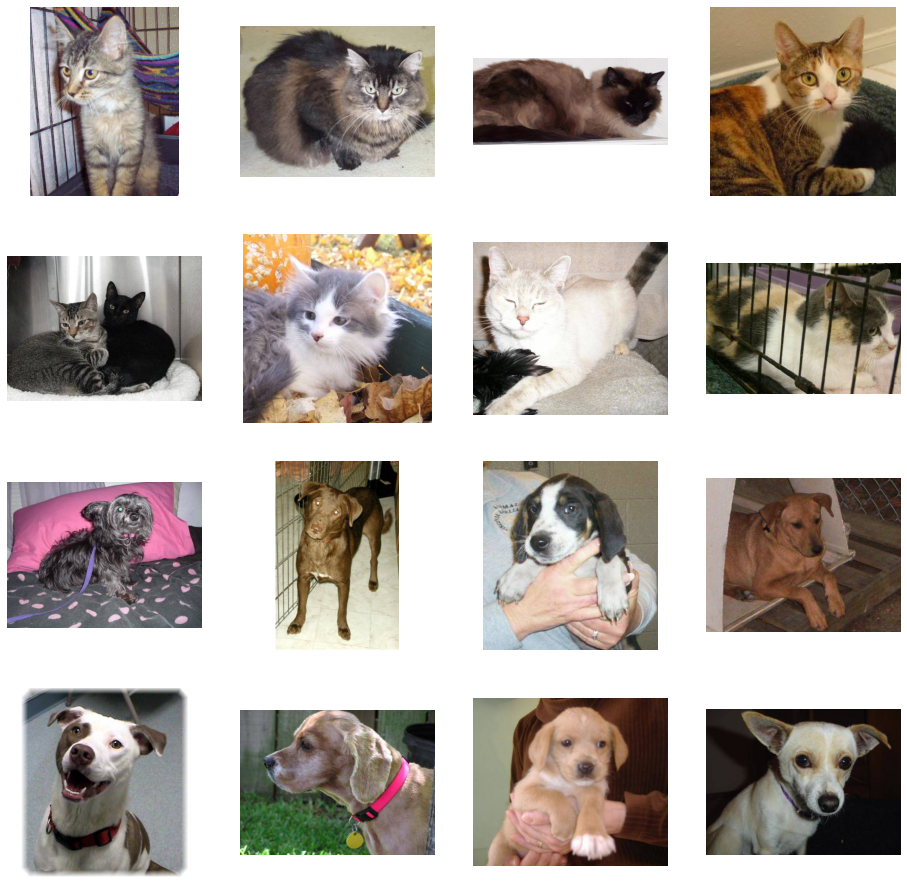

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [10]:
import tensorflow.keras as keras

In [14]:
img_input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(16, 3, activation='relu')(img_input)
x = keras.layers.MaxPool2D(2)(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Conv2D(64, 3, activation='relu')(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(img_input, output)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496 

In [16]:
model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.RMSprop(lr=0.001), metrics=[keras.metrics.Accuracy()])

/home/lisy09/develop/repo/research-to-applied-ml/venv/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

<ipython-input-18-06b7332a811c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15


2022-03-21 21:47:25.807041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-03-21 21:47:28.082056: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-21 21:47:28.212839: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 - 9s - loss: 0.9463 - accuracy: 0.0050 - val_loss: 0.6702 - val_accuracy: 0.0000e+00 - 9s/epoch - 93ms/step
Epoch 2/15
100/100 - 5s - loss: 0.6731 - accuracy: 0.0000e+00 - val_loss: 0.6638 - val_accuracy: 0.0000e+00 - 5s/epoch - 47ms/step
Epoch 3/15
100/100 - 5s - loss: 0.5876 - accuracy: 0.0000e+00 - val_loss: 0.5894 - val_accuracy: 0.0000e+00 - 5s/epoch - 47ms/step
Epoch 4/15
100/100 - 5s - loss: 0.5080 - accuracy: 0.0000e+00 - val_loss: 0.6187 - val_accuracy: 0.0000e+00 - 5s/epoch - 47ms/step
Epoch 5/15
100/100 - 5s - loss: 0.4160 - accuracy: 0.0000e+00 - val_loss: 0.6671 - val_accuracy: 0.0000e+00 - 5s/epoch - 47ms/step
Epoch 6/15
100/100 - 5s - loss: 0.3232 - accuracy: 5.0000e-04 - val_loss: 0.9216 - val_accuracy: 0.0000e+00 - 5s/epoch - 47ms/step
Epoch 7/15
100/100 - 5s - loss: 0.2229 - accuracy: 0.0015 - val_loss: 0.7701 - val_accuracy: 0.0000e+00 - 5s/epoch - 52ms/step
Epoch 8/15
100/100 - 5s - loss: 0.1634 - accuracy: 0.0065 - val_loss: 1.4427 - val_accuracy: 0.0060 - 

<ipython-input-19-a1d8b40c9e04>:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


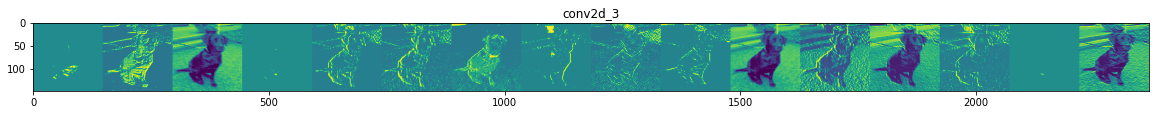

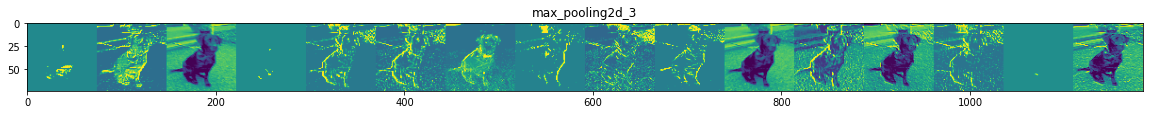

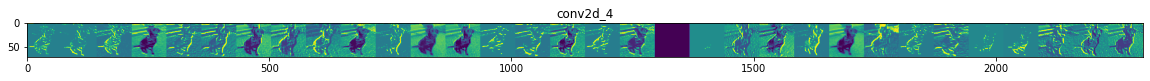

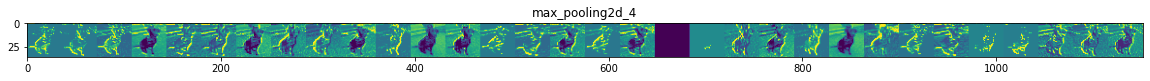

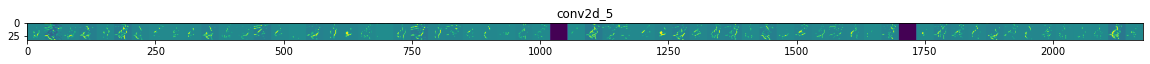

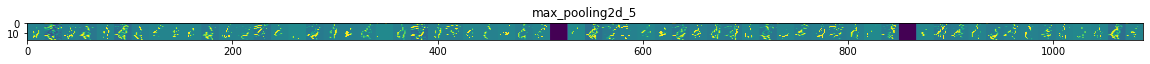

In [19]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

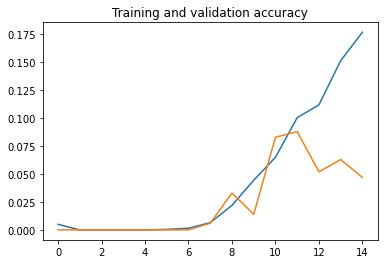

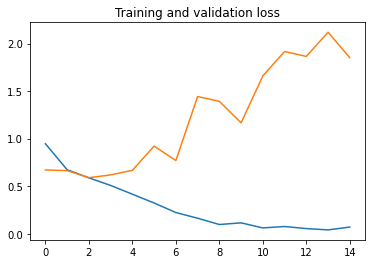

In [21]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)